<a href="https://colab.research.google.com/github/SatoshiEndoDEV/colab_sample/blob/main/signate_565music_LGBM%2BkNN_cv5%2Bpop10_region%2BTE%2Bitertools_hm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LGBM+kNN


cv5に変更

FE追加
* popularityを10の位で分類しなおし、regionとgroupbyして集約特徴量を生成する
* 各特徴量を0.1刻みなどに丸めてみる


CVアンサンブルを調和平均に変更

target count encodingを追加

itertoolsによる相互作用特徴量を追加

#signate CLI接続

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install signate

APIトークンを保存

In [3]:
! mkdir -p /root/.signate && cp /content/drive/MyDrive/signate/.signate/signate.json /root/.signate/

#ファイルダウンロード

In [4]:
! signate download -c 565

genre_labels.csv

sample_submit.csv

test.csv

train.csv


Download completed.


#ライブラリ

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

In [6]:
N_CLASSES = 11

In [7]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_sample_sub = pd.read_csv('/content/sample_submit.csv', header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv('/content/genre_labels.csv')

In [8]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

In [9]:
def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [10]:
df = merge_train_test(df_train, df_test)

#feature engineering



*   region+popularity10で集約
*   特徴項目を0.1刻みに分類



In [11]:
df['popularity10'] = df['popularity']//10

In [12]:
origin = ['duration_ms',
         'acousticness',
         'positiveness',
         'danceability',
         'loudness',
         'energy',
         'liveness',
         'speechiness',
         'instrumentalness',
]

In [13]:
for o in origin:
    df[f"{o}_mean"] = df.groupby(["region", "popularity10"]).transform(np.mean)[f"{o}"]
    df[f"{o}_median"] = df.groupby(["region", "popularity10"]).transform(np.median)[f"{o}"]
    df[f"{o}_max"] = df.groupby(["region", "popularity10"]).transform(np.max)[f"{o}"]
    df[f"{o}_min"] = df.groupby(["region", "popularity10"]).transform(np.min)[f"{o}"]
    df[f"{o}_25"] = df.groupby(["region", "popularity10"]).transform(lambda x: np.percentile(x, q=0.25))[f"{o}"]
    df[f"{o}_75"] = df.groupby(["region", "popularity10"]).transform(lambda x: np.percentile(x, q=0.75))[f"{o}"]
    df[f"{o}_zscore"] = df.groupby(["region", "popularity10"]).transform(lambda x: (x-np.mean(x))/np.std(x))[f"{o}"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  
/usr/local/lib/pyt

In [14]:
origin10 = ['duration_ms',
         'acousticness',
         'positiveness',
         'danceability',
         'energy',
         'liveness',
         'speechiness',
         'instrumentalness',
]

In [15]:
for o in origin10:
    exec(f'df["{o+str(10)}"]=df["{o}"]//0.1')

In [16]:
df["loudness10"] = round(np.abs(df["loudness"]))

target count encoding

In [17]:
#genreでone hot encoding
ohe = pd.get_dummies(df['genre'], prefix='genre')

In [18]:
#genre_-100は使用しないので削除
ohe.drop(['genre_-100'], axis =1, inplace=True)

In [19]:
df = df.join(ohe)

In [20]:
#genre_1 ,,, でカウント
for i in range(11):
    df[f'genre_{i}_tce'] = df.groupby(["region", "popularity10"]).transform(np.sum)[f'genre_{i}'].astype('int')

In [21]:
for j in range(11):
    df.drop([f'genre_{j}'], axis=1, inplace=True)

testにもtceが反映されているのでリークかも

kNN特徴量生成

In [22]:
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

In [23]:
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

In [24]:
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

In [25]:
df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

In [26]:
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self
    
    def transform(self, series):
        return series.map(self.counts).fillna(0)
    
    def fit_transform(self, series):
        return self.fit(series).transform(series)

In [27]:
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan

In [28]:
columns_label_enc = ["region"]
for col in columns_count_enc:
    df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "labelenc_" + col] = np.nan

In [29]:
class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train) 

In [30]:
df["log_tempo"] = np.log(df["tempo"])

In [31]:
gfe = GroupFeatureExtractor(
    "region", 
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
    ["zscore"]
)

In [32]:
df = pd.concat([df, gfe.fit_transform(df)], axis=1)

In [33]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
    
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self
    
    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)
        
        return df_knn

feature scaling

In [34]:
df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

相互作用特徴量

In [35]:
# itertoolsで組み合わせ表を生成する
# 組み合わせごとに加減乗除するforループを回す

std_feature = [
   'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',          
]

import itertools

iter_list = list(itertools.combinations(std_feature, 2))

In [40]:
for iter1, iter2 in iter_list:
    df[f"{iter1}-{iter2}-prod"] = df[iter1] * df[iter2]
    df[f"{iter1}-{iter2}-devid"] = df[iter1] / df[iter2]
    df[f"{iter1}-{iter2}-add"] = df[iter1] + df[iter2]
    df[f"{iter1}-{iter2}-sub"] = df[iter1] - df[iter2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented fr

分割

In [42]:
df_train, df_test = split_train_test(df)

In [43]:
target = df_train["genre"]

#parameters

In [44]:
learning_rate = 0.01

In [45]:
lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    #"metric": "None",
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": 0,
    "seed": 42,
}

In [57]:
knn_n_neighbors = 6

In [58]:
knn_features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans'
]

In [59]:
dict_feature_weights = {}
for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

In [60]:
for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    dict_feature_weights[col] = 1.0

In [61]:
dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

In [62]:
knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])

In [63]:
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()


features_categorical = ["labelenc_region"]
#features = features_numerical + features_categorical

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")
    
    df_trn = df_train.loc[indexes_trn,:].reset_index(drop=True)
    df_val = df_train.loc[indexes_val,:].reset_index(drop=True)
    target_trn = target[indexes_trn].reset_index(drop=True)
    target_val = target[indexes_val].reset_index(drop=True)
    
    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]
    
    
    features = df_trn.columns.tolist()
    features.remove("index")
    features.remove("genre")
    features.remove("region")
    features.remove("genre_name")


    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )
    
    lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    model = lgb.train(
        lgb_params,
        lgb_train, 
        num_round, 
        valid_sets=[lgb_train, lgb_valid], 
        verbose_eval=300,
        early_stopping_rounds=300 if num_round >= 1e8 else None,
        fobj=None,
        #feval=lgb_metric,
    )
    
    # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
    
    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
    
    # prediction for test data
    p = model.predict(df_test[features], num_iteration=prediction_round)
    predictions +=  1/p

predictions = N_SPLITS / predictions
print()

------------------------------ fold 0 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.766641	valid_1's multi_logloss: 0.874785
[600]	training's multi_logloss: 0.65761	valid_1's multi_logloss: 0.807225
[900]	training's multi_logloss: 0.600806	valid_1's multi_logloss: 0.791704
[1200]	training's multi_logloss: 0.557948	valid_1's multi_logloss: 0.7868
[1500]	training's multi_logloss: 0.522328	valid_1's multi_logloss: 0.788555
Early stopping, best iteration is:
[1317]	training's multi_logloss: 0.543296	valid_1's multi_logloss: 0.786459
------------------------------ fold 1 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.76339	valid_1's multi_logloss: 0.800717
[600]	training's multi_logloss: 0.656557	valid_1's multi_logloss: 0.734215
[900]	training's multi_logloss: 0.599136	valid_1's multi_logloss: 0.720014
[1200]	training's multi_logloss: 0.555771	valid_1's multi_logloss: 0.717462
Early stopping, best iteration is:
[1113]	training's multi_logloss: 0.567499	valid_1's multi_logloss: 0.71691
------------------------------ fold 2 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.764256	valid_1's multi_logloss: 0.810743
[600]	training's multi_logloss: 0.656945	valid_1's multi_logloss: 0.74308
[900]	training's multi_logloss: 0.59934	valid_1's multi_logloss: 0.728539
[1200]	training's multi_logloss: 0.555981	valid_1's multi_logloss: 0.725823
Early stopping, best iteration is:
[1162]	training's multi_logloss: 0.561003	valid_1's multi_logloss: 0.725602
------------------------------ fold 3 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.776179	valid_1's multi_logloss: 0.772654
[600]	training's multi_logloss: 0.667287	valid_1's multi_logloss: 0.708409
[900]	training's multi_logloss: 0.609749	valid_1's multi_logloss: 0.698423
Early stopping, best iteration is:
[880]	training's multi_logloss: 0.613064	valid_1's multi_logloss: 0.698351
------------------------------ fold 4 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.779283	valid_1's multi_logloss: 0.779198
[600]	training's multi_logloss: 0.66958	valid_1's multi_logloss: 0.706878
[900]	training's multi_logloss: 0.612288	valid_1's multi_logloss: 0.691287
[1200]	training's multi_logloss: 0.569545	valid_1's multi_logloss: 0.68894
[1500]	training's multi_logloss: 0.534495	valid_1's multi_logloss: 0.686769
[1800]	training's multi_logloss: 0.503688	valid_1's multi_logloss: 0.687059
Early stopping, best iteration is:
[1672]	training's multi_logloss: 0.516388	valid_1's multi_logloss: 0.686456
------------------------------ fold 5 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.775042	valid_1's multi_logloss: 0.864174
[600]	training's multi_logloss: 0.664115	valid_1's multi_logloss: 0.793449
[900]	training's multi_logloss: 0.60624	valid_1's multi_logloss: 0.779746
[1200]	training's multi_logloss: 0.563378	valid_1's multi_logloss: 0.779428
Early stopping, best iteration is:
[1071]	training's multi_logloss: 0.580661	valid_1's multi_logloss: 0.778321
------------------------------ fold 6 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.787843	valid_1's multi_logloss: 0.746486
[600]	training's multi_logloss: 0.677609	valid_1's multi_logloss: 0.645459
[900]	training's multi_logloss: 0.620561	valid_1's multi_logloss: 0.624502
[1200]	training's multi_logloss: 0.578427	valid_1's multi_logloss: 0.622057
[1500]	training's multi_logloss: 0.543259	valid_1's multi_logloss: 0.623003
Early stopping, best iteration is:
[1242]	training's multi_logloss: 0.57317	valid_1's multi_logloss: 0.621617
------------------------------ fold 7 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.758127	valid_1's multi_logloss: 0.869044
[600]	training's multi_logloss: 0.650354	valid_1's multi_logloss: 0.803131
[900]	training's multi_logloss: 0.592271	valid_1's multi_logloss: 0.794332
Early stopping, best iteration is:
[895]	training's multi_logloss: 0.593106	valid_1's multi_logloss: 0.794197
------------------------------ fold 8 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.767112	valid_1's multi_logloss: 0.901569
[600]	training's multi_logloss: 0.657517	valid_1's multi_logloss: 0.841797
[900]	training's multi_logloss: 0.599469	valid_1's multi_logloss: 0.827765
[1200]	training's multi_logloss: 0.556143	valid_1's multi_logloss: 0.821775
[1500]	training's multi_logloss: 0.520394	valid_1's multi_logloss: 0.819857
[1800]	training's multi_logloss: 0.489564	valid_1's multi_logloss: 0.818769
[2100]	training's multi_logloss: 0.462547	valid_1's multi_logloss: 0.81871
[2400]	training's multi_logloss: 0.438079	valid_1's multi_logloss: 0.818986
Early stopping, best iteration is:
[2239]	training's multi_logloss: 0.450943	valid_1's multi_logloss: 0.818368
------------------------------ fold 9 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.761303	valid_1's multi_logloss: 0.884671
[600]	training's multi_logloss: 0.655842	valid_1's multi_logloss: 0.790931
[900]	training's multi_logloss: 0.598768	valid_1's multi_logloss: 0.765932
[1200]	training's multi_logloss: 0.555266	valid_1's multi_logloss: 0.758752
[1500]	training's multi_logloss: 0.519348	valid_1's multi_logloss: 0.757371
Early stopping, best iteration is:
[1452]	training's multi_logloss: 0.524744	valid_1's multi_logloss: 0.757159
------------------------------ fold 10 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.781698	valid_1's multi_logloss: 0.818231
[600]	training's multi_logloss: 0.671142	valid_1's multi_logloss: 0.745149
[900]	training's multi_logloss: 0.612935	valid_1's multi_logloss: 0.731358
[1200]	training's multi_logloss: 0.570064	valid_1's multi_logloss: 0.727719
[1500]	training's multi_logloss: 0.534807	valid_1's multi_logloss: 0.726454
[1800]	training's multi_logloss: 0.504187	valid_1's multi_logloss: 0.72665
Early stopping, best iteration is:
[1556]	training's multi_logloss: 0.528782	valid_1's multi_logloss: 0.725955
------------------------------ fold 11 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.763713	valid_1's multi_logloss: 0.785734
[600]	training's multi_logloss: 0.656246	valid_1's multi_logloss: 0.716255
[900]	training's multi_logloss: 0.598708	valid_1's multi_logloss: 0.706236
[1200]	training's multi_logloss: 0.55448	valid_1's multi_logloss: 0.703932
Early stopping, best iteration is:
[1195]	training's multi_logloss: 0.555161	valid_1's multi_logloss: 0.703831
------------------------------ fold 12 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.75694	valid_1's multi_logloss: 0.895072
[600]	training's multi_logloss: 0.649953	valid_1's multi_logloss: 0.838149
[900]	training's multi_logloss: 0.59198	valid_1's multi_logloss: 0.833112
[1200]	training's multi_logloss: 0.548406	valid_1's multi_logloss: 0.835361
Early stopping, best iteration is:
[927]	training's multi_logloss: 0.587583	valid_1's multi_logloss: 0.832779
------------------------------ fold 13 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.77206	valid_1's multi_logloss: 0.845057
[600]	training's multi_logloss: 0.662638	valid_1's multi_logloss: 0.770015
[900]	training's multi_logloss: 0.605669	valid_1's multi_logloss: 0.75665
[1200]	training's multi_logloss: 0.562973	valid_1's multi_logloss: 0.757186
Early stopping, best iteration is:
[1001]	training's multi_logloss: 0.590174	valid_1's multi_logloss: 0.756199
------------------------------ fold 14 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.778324	valid_1's multi_logloss: 0.817568
[600]	training's multi_logloss: 0.667381	valid_1's multi_logloss: 0.748493
[900]	training's multi_logloss: 0.609563	valid_1's multi_logloss: 0.745312
Early stopping, best iteration is:
[728]	training's multi_logloss: 0.640083	valid_1's multi_logloss: 0.744514



CV score
  f1:  0.65404

              precision    recall  f1-score   support

           0       0.79      0.59      0.68        32
           1       0.59      0.38      0.46       205
           2       0.72      0.59      0.65       191
           3       0.80      0.78      0.79       362
           4       0.68      0.58      0.63        45
           5       0.60      0.46      0.52       126
           6       0.56      0.40      0.47        50
           7       0.63      0.62      0.63       334
           8       0.73      0.80      0.76      1305
           9       0.80      0.83      0.82        59
          10       0.79      0.82      0.80      1337

    accuracy                           0.74      4046
   macro avg       0.70      0.62      0.65      4046
weighted avg       0.73      0.74      0.73      4046



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


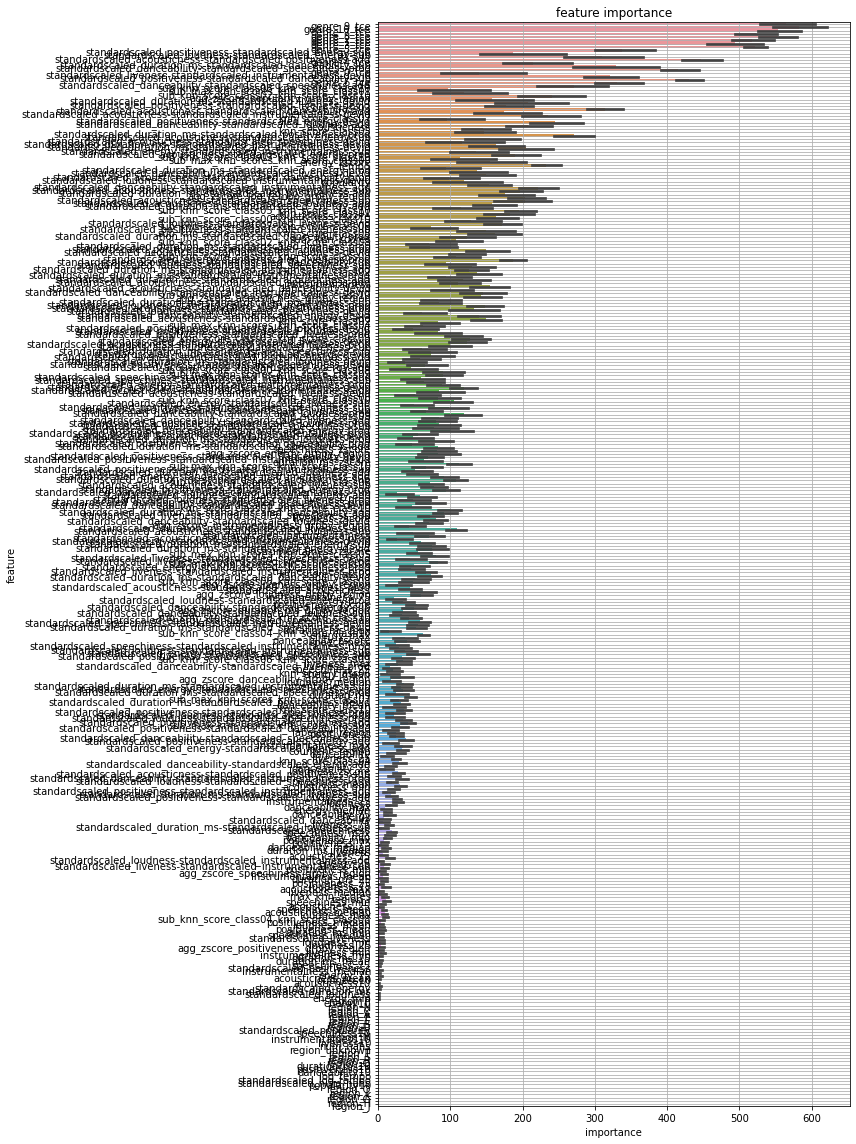

In [64]:
df_test["prediction"] = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

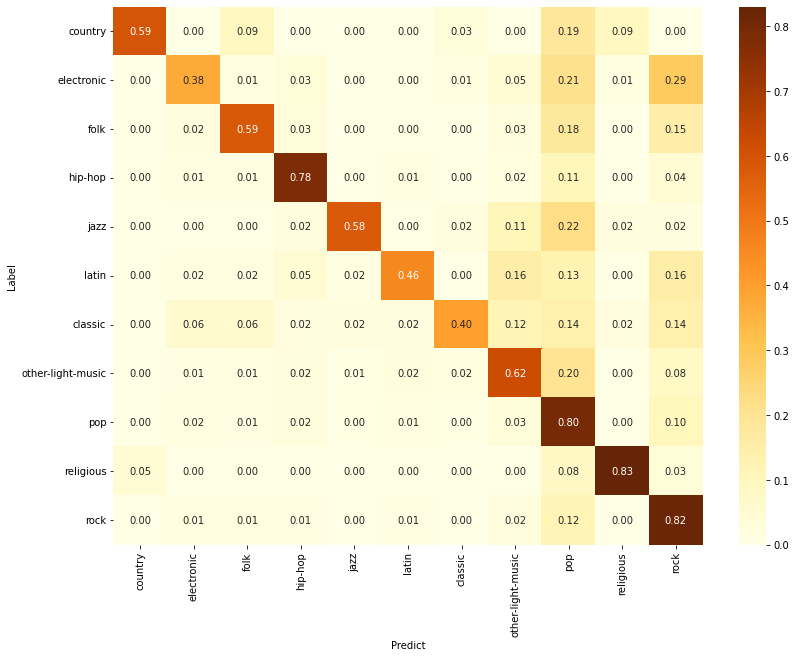

In [65]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()

#サブミット

In [66]:
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submit-lgbm+kNN-cv5+pop10*region+TE+Itertools-hm.csv", header=None, index=False)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [67]:
! signate submit -c 565 -n "lgbm+kNN cv5 neibor=10 pop10*region + feature//10 cv + target count encoding + itertools as hearmonic mean" submit-lgbm+kNN-cv5+pop10*region+TE+Itertools-hm.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.
